<a href="https://colab.research.google.com/github/jklee96/MNIST_AutoEncoder/blob/main/MNIST_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MNIST 데이터를 사용하여 합성곱 오토인코더(Convolutional Autoencoder)를 구현하고 학습시키는 예제입니다.

먼저, 모델 구현에 필요한 PyTorch 관련 라이브러리와 데이터 시각화를 위한 matplotlib, numpy를 불러옵니다.

(중요) Colab의 메뉴에서 **'런타임' > '런타임 유형 변경'**을 선택하고, 하드웨어 가속기를 GPU로 설정해주세요. GPU를 사용하면 모델 학습 속도를 크게 향상시킬 수 있습니다.

In [2]:
# PyTorch 관련 기본 라이브러리
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# torchvision 라이브러리 (데이터셋 및 변환 기능 제공)
import torchvision
import torchvision.transforms as transforms

# 시각화 및 계산을 위한 라이브러리
import matplotlib.pyplot as plt
import numpy as np
import os

PyTorch가 GPU를 사용할 수 있는지 확인하고, 사용 가능하다면 device를 'cuda'로 설정합니다. 만약 GPU를 사용할 수 없는 환경이라면 CPU를 사용하도록 설정합니다. 이 코드를 통해 모델의 텐서 연산이 지정된 장치에서 수행됩니다.

In [3]:
# GPU 사용 가능 여부 확인 후 device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


오토인코더는 인코더(Encoder)와 디코더(Decoder) 두 부분으로 구성됩니다.

인코더: 입력 이미지를 저차원의 잠재 공간(latent space) 벡터로 압축합니다. 여기서는 3개의 Conv2d (합성곱) 레이어를 사용하여 이미지의 특징을 추출하고 차원을 점차 줄입니다.

디코더: 인코더가 만든 잠재 벡터를 다시 원본 이미지 크기로 복원(재구성)합니다. ConvTranspose2d 레이어를 사용하여 이미지의 차원을 점차 늘립니다. 마지막 Sigmoid 활성화 함수는 픽셀 값을 0과 1 사이로 만들어줍니다.

forward 함수는 데이터가 모델을 통과하는 순서(인코더 -> 디코더)를 정의합니다.

In [9]:
# 커스텀 신경망 클래스 정의
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # 인코더 정의
        self.encoder = nn.Sequential(
            # 입력: 1 x 28 x 28
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1), # -> 출력: 16 x 14 x 14
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # -> 출력: 32 x 7 x 7
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=0), # -> 출력: 64 x 1 x 1 (잠재 벡터)
        )

        # 디코더 정의
        self.decoder = nn.Sequential(
            # 입력: 64 x 1 x 1
            nn.ConvTranspose2d(64, 32, kernel_size=7, stride=1, padding=0), # -> 출력: 32 x 7 x 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), # -> 출력: 16 x 14 x 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1), # -> 출력: 1 x 28 x 28
            nn.Sigmoid() # 픽셀 값을 0과 1 사이로 조정
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

모델 학습에 필요한 하이퍼파라미터를 정의하고, 손으로 쓴 숫자 이미지로 구성된 MNIST 데이터셋을 불러옵니다.

epochs: 전체 데이터셋을 몇 번 반복하여 학습할지 결정합니다.

batch_size: 한 번에 학습할 데이터의 양을 결정합니다.

learning_rate: 모델의 가중치를 얼마나 업데이트할지 결정하는 학습률입니다.

transforms.ToTensor(): PIL 이미지나 numpy 배열을 PyTorch 텐서로 변환하고, 픽셀 값을 0 ~ 255에서 0.0 ~ 1.0 사이로 정규화합니다.

DataLoader: 데이터셋을 batch_size에 맞게 나누고, 학습 시 데이터를 무작위로 섞어주는(shuffle) 등의 편의 기능을 제공합니다.

In [10]:
# 하이퍼파라미터 정의
epochs = 10
batch_size = 64
learning_rate = 0.001

# 이미지 변환 설정
transform = transforms.ToTensor()

# MNIST 훈련 데이터셋 및 테스트 데이터셋 다운로드
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoader 객체 생성 (배치 단위로 데이터를 로드)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 50.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.68MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.76MB/s]


본격적인 학습에 앞서 다음 세 가지를 준비합니다.

모델: 앞에서 정의한 ConvAutoencoder 클래스의 인스턴스를 생성하고, .to(device)를 통해 GPU 메모리로 보냅니다.

손실 함수(Criterion): 모델의 예측(복원된 이미지)과 실제 값(원본 이미지)의 차이를 계산합니다. 오토인코더는 주로 MSELoss (평균 제곱 오차)를 사용하여 픽셀 간 차이를 측정합니다.

옵티마이저(Optimizer): 계산된 손실을 바탕으로 모델의 가중치를 업데이트하는 역할을 합니다. 여기서는 가장 널리 쓰이는 Adam 옵티마이저를 사용합니다.

In [11]:
# 모델 인스턴스 생성 및 device로 전송
model = ConvAutoencoder().to(device)

# 손실 함수 정의 (Mean Squared Error)
criterion = nn.MSELoss()

# 옵티마이저 정의 (Adam)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for 루프를 통해 epochs 수만큼 학습을 반복합니다.

train_loader에서 배치 단위로 이미지 데이터를 가져옵니다.

이미지를 모델에 입력하여 output (복원된 이미지)을 얻습니다. (순전파)

criterion을 이용해 output과 원본 images 사이의 loss (손실)를 계산합니다.

optimizer.zero_grad(): 이전 배치의 기울기 값을 초기화합니다.

loss.backward(): 손실에 대한 각 가중치의 기울기를 계산합니다. (역전파)

optimizer.step(): 계산된 기울기를 바탕으로 모델의 가중치를 업데이트합니다.

매 에폭이 끝날 때마다 학습 손실을 출력하여 학습 진행 상황을 확인합니다.

In [12]:
# 훈련 루프
for epoch in range(epochs):
    for images, _ in train_loader:  # 레이블은 사용하지 않으므로 _ 로 받음
        # 이미지를 설정된 device로 보냄
        images = images.to(device)

        # 순방향 전달
        output = model(images)
        loss = criterion(output, images)  # 손실 계산 (복원된 이미지와 원본 이미지 차이)

        # 역방향 전파 및 최적화
        optimizer.zero_grad()  # 경사도(gradient) 초기화
        loss.backward()      # 그라디언트 계산
        optimizer.step()     # 모델 파라미터 업데이트

    # 각 epoch마다 loss 출력
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.0076
Epoch [2/10], Loss: 0.0049
Epoch [3/10], Loss: 0.0036
Epoch [4/10], Loss: 0.0035
Epoch [5/10], Loss: 0.0032
Epoch [6/10], Loss: 0.0029
Epoch [7/10], Loss: 0.0023
Epoch [8/10], Loss: 0.0028
Epoch [9/10], Loss: 0.0025
Epoch [10/10], Loss: 0.0023


학습된 오토인코더의 성능을 시각적으로 확인합니다.

test_loader에서 테스트 이미지 한 배치를 가져옵니다.

학습된 모델에 이미지를 통과시켜 복원된 이미지를 생성합니다.

matplotlib을 사용하여 원본 이미지와 모델이 복원한 이미지를 나란히 표시합니다.

결과를 통해 모델이 이미지의 주요 특징을 얼마나 잘 압축하고 복원하는지 확인할 수 있습니다.

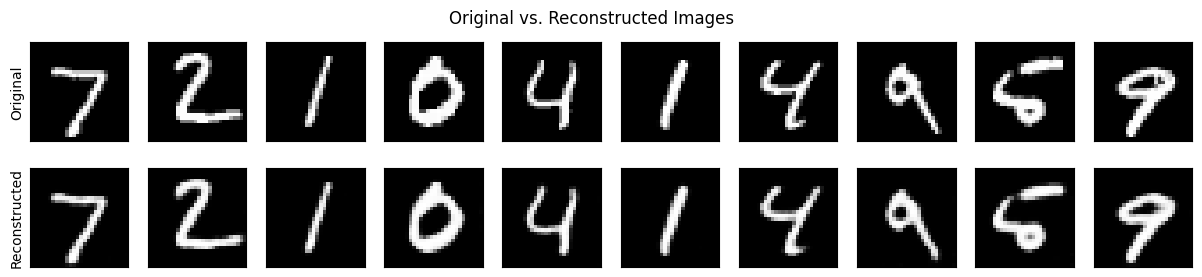

In [13]:
# 시각화를 위해 테스트 로더에서 이미지 한 배치를 가져옴
dataiter = iter(test_loader)
images, _ = next(dataiter)

# 모델을 통해 이미지 복원
output = model(images.to(device))

# 시각화를 위해 텐서를 cpu로 옮기고 numpy 배열로 변환
images = images.numpy()
output = output.cpu().detach().numpy()

# 원본과 복원된 이미지 비교 시각화 (상위 10개)
num_images_to_show = 10
fig, axes = plt.subplots(nrows=2, ncols=num_images_to_show, figsize=(15, 3))

for i in range(num_images_to_show):
    # 원본 이미지
    ax = axes[0, i]
    ax.imshow(np.squeeze(images[i]), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    if i == 0:
        ax.set_ylabel('Original')

    # 복원된 이미지
    ax = axes[1, i]
    ax.imshow(np.squeeze(output[i]), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    if i == 0:
        ax.set_ylabel('Reconstructed')

plt.suptitle('Original vs. Reconstructed Images')
plt.show()